# Analysing and forecasting exportation and importation of Brazil
---

## Brazilian exports and imports

In [810]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('fivethirtyeight')

In [4]:
# reading csv
comexstat = pd.read_csv('data_comexstat.csv', encoding = "ISO-8859-1")

In [9]:
# transforming date to datetime
comexstat.date = pd.to_datetime(comexstat.date, format='%Y-%m-%d')

In [13]:
# checking dataframe
# there are no null values
comexstat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117965 entries, 0 to 117964
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   date     117965 non-null  datetime64[ns]
 1   product  117965 non-null  object        
 2   state    117965 non-null  object        
 3   country  117965 non-null  object        
 4   type     117965 non-null  object        
 5   route    117965 non-null  object        
 6   tons     117965 non-null  float64       
 7   usd      117965 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 7.2+ MB


### Show the evolution of total monthly and total annual exports from Brazil (all states and to everywhere) of ‘soybeans’, ‘soybean oil’ and ‘soybean meal’

In [136]:
#Important function for a cleaner code

# function to get total monthly and total annual exports or imports from Brazil
def get_product_monthly_annualy(df, product, ioe):
    '''Return total monthly and total annual import or exports (ioe) in usd and
    tons from Brazil from all states and to everywhere of product in df
    '''
    
    # get df by product and type
    export_df = df[(df['product'] == product) & (df['type'] == ioe)]
    
    # get total monthly exports of product (mep)
    mep = export_df.groupby(pd.Grouper(key='date', freq="MS"))[['tons', 'usd']].sum()
    
    # annual exports product (aep)
    aep = export_df.groupby(pd.Grouper(key='date', freq="YS"))[['tons', 'usd']].sum()
    
    return mep, aep

# function to plot total 
def plot_tmta_product(mep, aep, product):
    plt.figure(figsize=(12,8))

    ax1 = plt.subplot(221)
    ax1.plot(mep.index, mep.usd.values/1e9)
    plt.ylabel('USD (in billions)')
    plt.title('Monthly', fontsize=16)
    plt.xticks(rotation=30)

    ax2 = plt.subplot(222)
    ax2.plot(mep.index, mep.tons.values/1e6)
    plt.ylabel('Tons (in millions)')
    plt.title('Monthly', fontsize=16)
    plt.xticks(rotation=30)

    ax3 = plt.subplot(223)
    ax3.plot(aep.index, aep.usd.values/1e9)
    plt.ylabel('USD (in billions)', fontsize=16)
    plt.title('Annual', fontsize=16)
    plt.xticks(rotation=30)

    ax4 = plt.subplot(224)
    ax4.plot(aep.index, aep.tons.values/1e6)
    plt.ylabel('Tons (in millions)')
    plt.title('Annual', fontsize=16)
    plt.xticks(rotation=30)

    plt.tight_layout()
    plt.suptitle(f'Exports of {product} from Brazil', x=0.5, y=1.05, fontsize=18)
    plt.show()

##### Soybeans

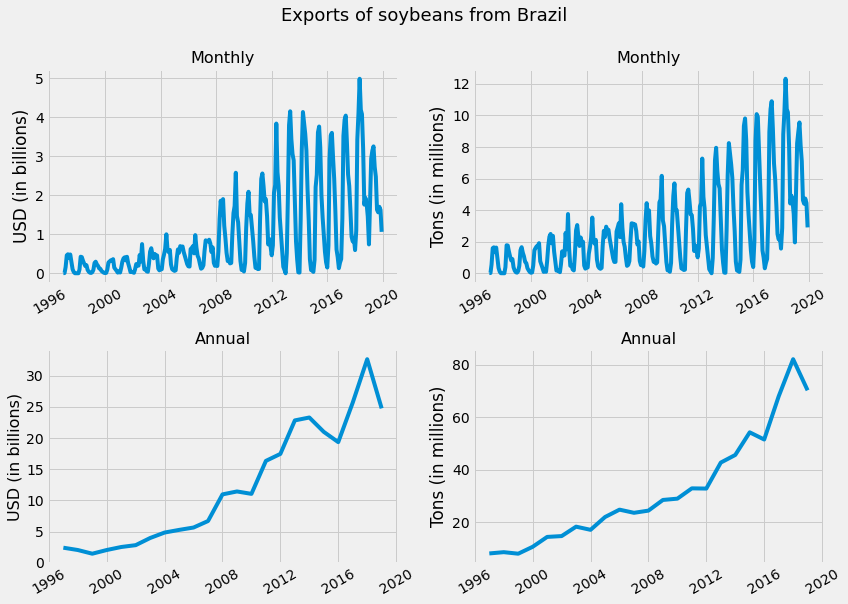

In [137]:
mes, aes = get_product_monthly_annualy(comexstat, 'soybeans', ioe='Export')
plot_tmta_product(mes, aes, product='soybeans')

We see from the total monthly exports of soybeans that they have seasonality of one year. The export start the year at a low level and rises until approximately half of the year, when it starts to decrease again. This pattern repeats each year.

With the total annual exports graph we see a rising trend in the exports.

##### Soybean oil

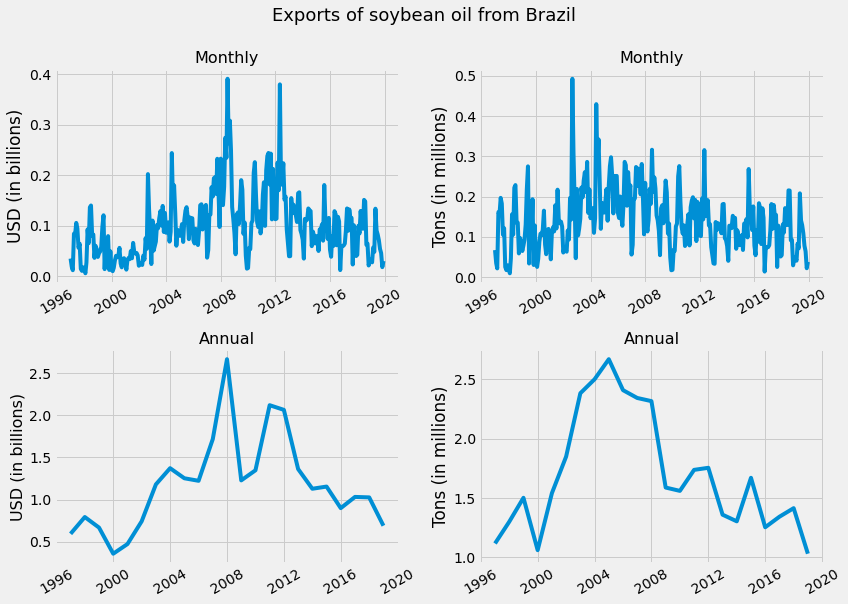

In [140]:
meso, aeso = get_product_monthly_annualy(comexstat, 'soybean_oil', ioe='Export')
plot_tmta_product(meso, aeso, product='soybean oil')

Again, we see some sort of seasonality, but this time the exports has a rising trend in USD until 2008, when it started to decrease. Meanwhile, the exports in tons has a rising trend until 2005, meaning a variation of the p price of soybean oil.

##### Soybean meal

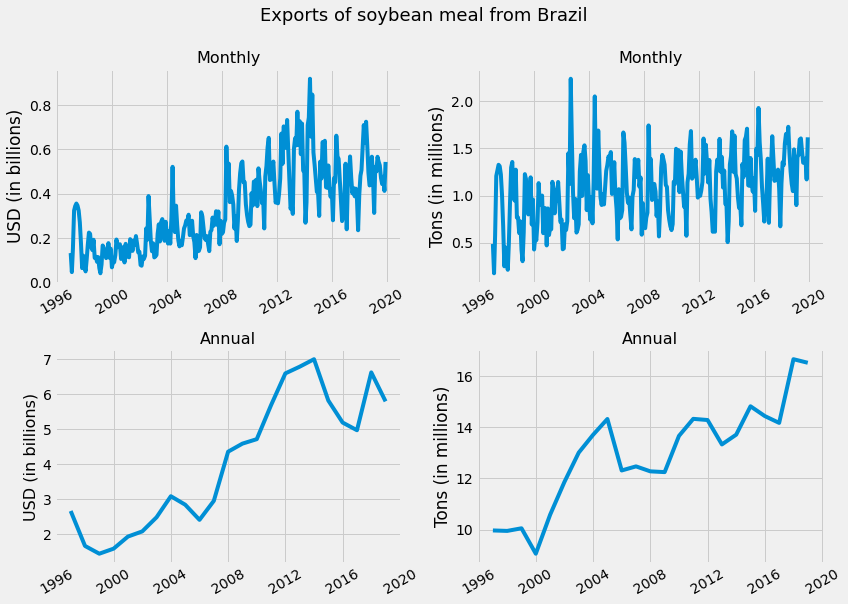

In [141]:
mesm, aesm = get_product_monthly_annualy(comexstat, 'soybean_meal', ioe='Export')
plot_tmta_product(mesm, aesm, product='soybean meal')

Again, we see seasonality and a upward trend of exports of soybean meal.

### What are the 3 most important products exported by Brazil in the last 5 years?

In [144]:
# getting different products
products = comexstat['product'].unique()

In [194]:
# getting dataframe of the last 5 years for each product
df_dict = {}
for p in products:
    x = comexstat[(comexstat['product'] == p) & (comexstat['type'] == 'Export') 
                & (comexstat['date'].dt.year >= max(comexstat['date'].dt.year-4))]
    df_dict[p] = x.groupby(pd.Grouper(key='date', freq="YS"))['usd'].sum()

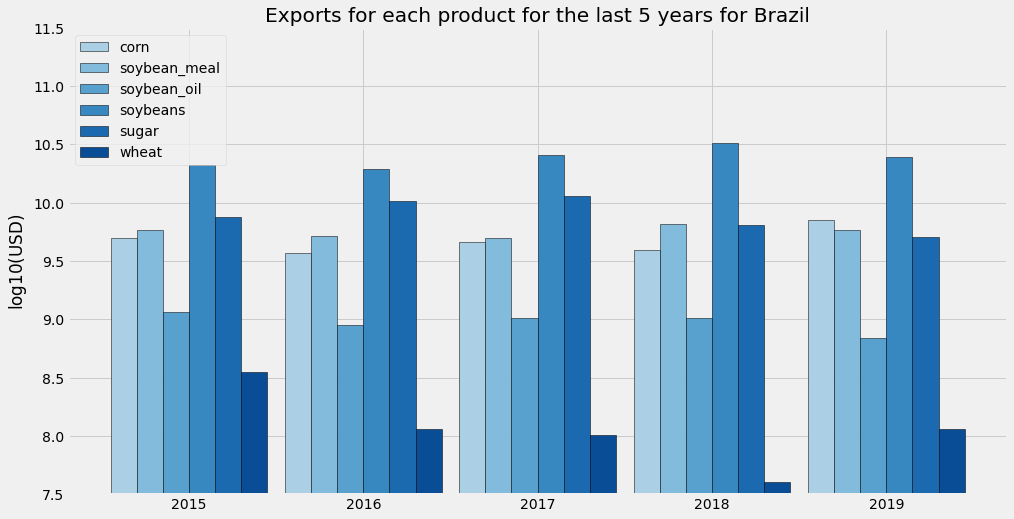

In [281]:
# plotting a barplot of the values of the exports for each year and product in a log scale to make 
# visualization better
color = sns.color_palette('Blues', len(products)+2)
plt.figure(figsize=(15,8))
w = 0.15
pos = 0.375
for i, p in enumerate(products):
    plt.bar(df_dict[p].index.year-pos, np.log10(df_dict[p].values), width=w, 
            label=f'{p}', color=color[i+2], ec='k')
    pos -= 0.15

plt.ylabel('$\log10{(\mathrm{USD})}$')
plt.ylim(7.5, 11.5)
plt.title('Exports for each product for the last 5 years for Brazil')
plt.legend(loc=2)
plt.show()

From this graph we can already see that for the last 5 years soybeans, sugar and soybean meal were the most important products exported by Brazil, except for the last year (2019) where corn became more important than soybean meal and sugar.

To make it even clearer, let's make a graph with the total amount of USD that was exportedd in the last 5 years for each product.

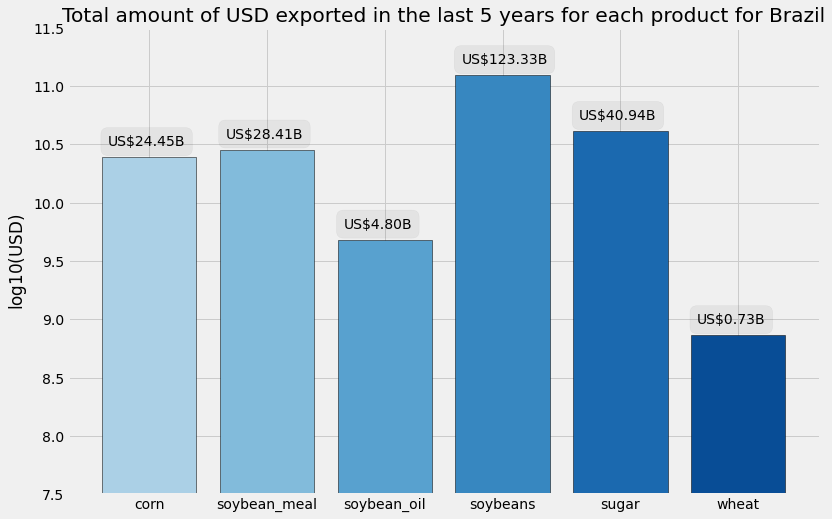

In [312]:
plt.figure(figsize=(12,8))
w = 0.8 
for i, p in enumerate(products):
    val = np.log10(df_dict[p].values.sum())
    x, y = i-0.35, val+0.1
    plt.bar(p, val, width=w, color=color[i+2], ec='k')
    plt.annotate('US\$%.2fB' % (10**val/1e9), (x,y), fontsize=14, color='k', 
                bbox=dict(facecolor='k', edgecolor='black', boxstyle='round', pad=0.5, alpha=0.05))

plt.ylabel('$\log10{(\mathrm{USD})}$')
plt.ylim(7.5, 11.5)
plt.title('Total amount of USD exported in the last 5 years for each product for Brazil')
plt.show()

As expected, soybeans, sugar and soybean meal are the 3 most important exports for the last 5 years. What is impressive is that soybeans are by far the most important product exported by Brazil. The value in USD exported by soybeans was more than 3 times larger than the 2 most important product, sugar, in the last 5 years.

### What are the main routes through which Brazil have been exporting ‘corn’ in the last few years? Are there differences in the relative importance of routes depending on the product?

In [285]:
routes = comexstat.route.unique()

In [345]:
# exports for each route for the last 10 years
corn_df = comexstat[(comexstat['product'] == 'corn') & (comexstat['type'] == 'Export') 
                   & (comexstat['date'].dt.year >= max(comexstat['date'].dt.year-9))]
corn_df = corn_df.groupby([pd.Grouper(key='date', freq="YS"), 'route'])['usd'].sum()

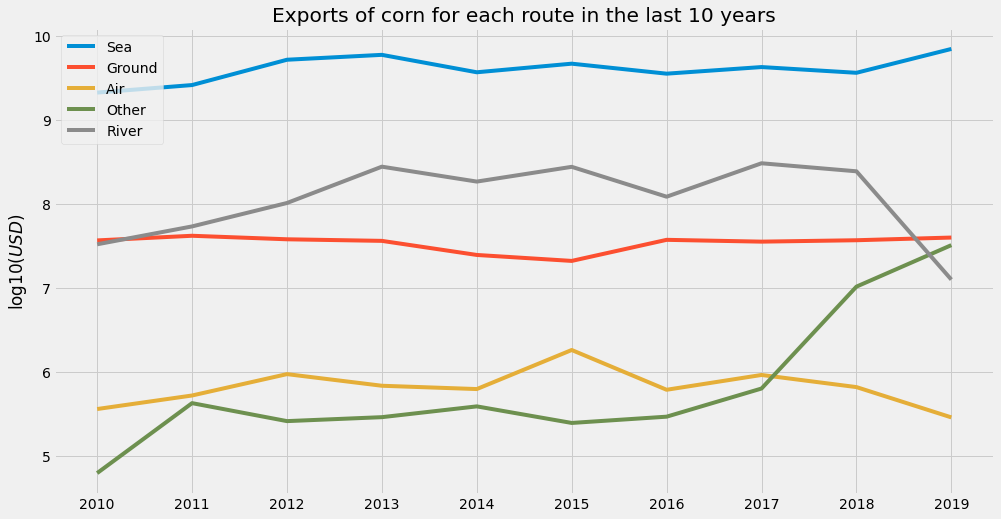

In [432]:
years = list(set(corn_df.index.get_level_values(0).year))
years.sort()

plt.figure(figsize=(15,8))
             
for i, r in enumerate(routes):
    val = np.log10(corn_df.loc[corn_df.index.get_level_values(0), r].values)
    plt.plot(years, val, label=f'{r}')
    
plt.legend(loc=2)
plt.xticks(years)
plt.ylabel('$\log10{(USD)}$')
plt.title('Exports of corn for each route in the last 10 years')
plt.show()

From the above graph we see that the 3 most important route in the past 10 years are Sea, River and Ground in descendent order of importance. In the last year, River lost some of its importance, while Other routes became more important.

#####  Are there differences in the relative importance of routes depending on the product?

Let's sum the total amount of exports for each product for each route in the last ten years and compre them.

In [429]:
# getting a dictionary with a dataframe for each product
df_dict = {}
for p in products:
    x = comexstat[(comexstat['product'] == p) & (comexstat['type'] == 'Export') 
                & (comexstat['date'].dt.year >= max(comexstat['date'].dt.year-9))]
    df_dict[p] = x.groupby('route')['usd'].sum()

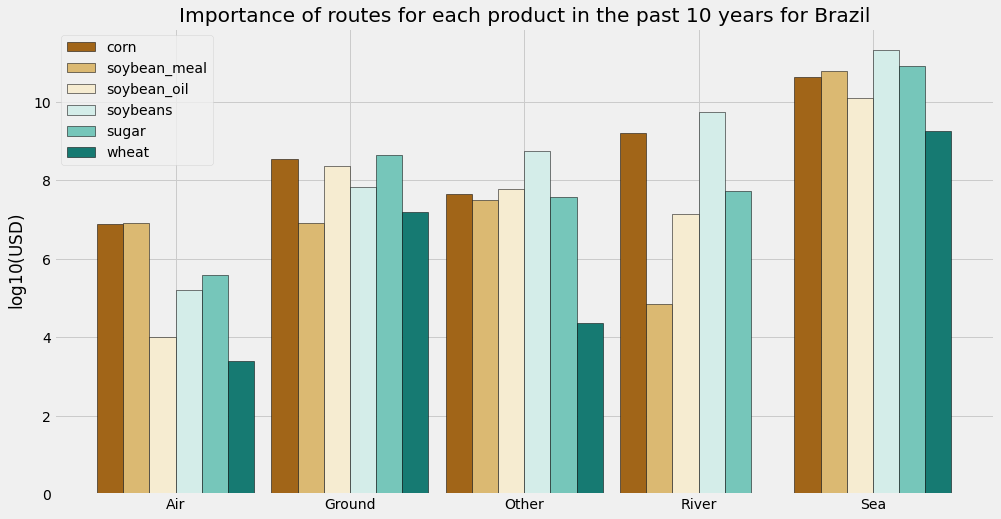

In [521]:
color = sns.color_palette('BrBG', len(products))
plt.figure(figsize=(15,8))
w = 0.15
pos = 0.375
aux = dict(enumerate(df_dict['corn'].index.values))
for i, p in enumerate(products):
    x = np.array([num for num in list(a.keys()) if a[num] in df_dict[p].index.values])
    val = np.log10(df_dict[p].values)
    plt.bar(x-pos, val, width=w, label=f'{p}', color=color[i], ec='k')
    pos -= 0.15

plt.ylabel('$\log10{(\mathrm{USD})}$')
plt.title('Importance of routes for each product in the past 10 years for Brazil')
plt.xticks(ticks=list(aux.keys()), labels = list(aux.values()))
plt.legend(loc=2)
plt.show()

Yes, there are differences in the relative importance of routes depending on the product. The main property of the graph before is that for all products the sea route is the most important. Let's analyse one by one for other routes.

- corn: The second most import route is River and the third is Ground.
- soybean meal: The second most import route is Other and the third is a tie between Air and Ground.
- soybean oil: The second most import route is Ground and the third is Other.
- soybeans: The second most import route is River and the third is Other.
- sugar: The second most import route is Ground and the third is River.
- wheat: The second most import route is Ground and the third is Other. This is a special case because there is no exports using river routes.

These items from before and the graph confirm that there are differences in the relative importance of routes depending of the product.

### Which countries have been the most important trade partners for Brazil in terms of ‘corn’ and ‘sugar’ in the last 3 years?

For the trade partners we need to find the countries that exports the largest amount to Brazil as well as imports the largest amount from Brazil. Let us take the 3 most important trade partners.

In [546]:
data = comexstat[(comexstat['product'].isin(['corn', 'sugar'])) & 
                 (comexstat['date'].dt.year >= max(comexstat['date'].dt.year-2))]
data = data.groupby(['country', 'type', 'product'], as_index=False)['usd'].sum()

In [564]:
# the most important countries we import products 
# corn
imported_corn = data[(data['type'] == 'Import') & 
                     (data['product'] == 'corn')].sort_values(by='usd', ascending=False)
exported_corn = data[(data['type'] == 'Export') & 
                     (data['product'] == 'corn')].sort_values(by='usd', ascending=False)

#sugar
imported_sugar = data[(data['type'] == 'Import') & 
                     (data['product'] == 'sugar')].sort_values(by='usd', ascending=False)
exported_sugar = data[(data['type'] == 'Export') & 
                     (data['product'] == 'sugar')].sort_values(by='usd', ascending=False)

##### Corn

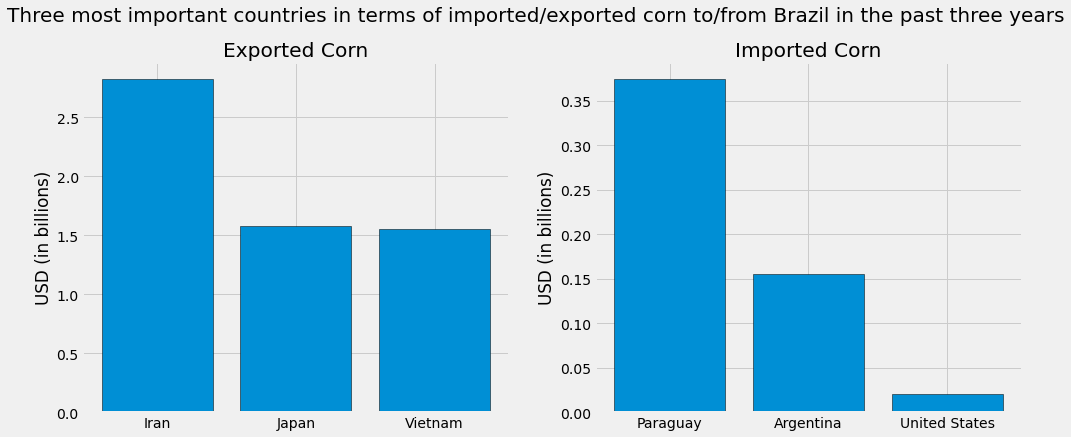

In [586]:
# corn
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.bar(exported_corn['country'].head(3), exported_corn['usd'].head(3)/1e9, ec='k')
plt.ylabel('USD (in billions)')
plt.title('Exported Corn')

plt.subplot(122)
plt.bar(imported_corn['country'].head(3), imported_corn['usd'].head(3)/1e9, ec='k')
plt.ylabel('USD (in billions)')
plt.title('Imported Corn')

plt.suptitle('Three most important countries in terms of imported/exported corn to/from Brazil in the past three years', 
             x=0.5, y=1.01, fontsize=20)
plt.show()

In terms of exported corn, the three most important trade partners are Iran, Japan and Vietnam, while in terms of imported corn the most important traders are Paraguay, Argentina and United States.

##### Sugar

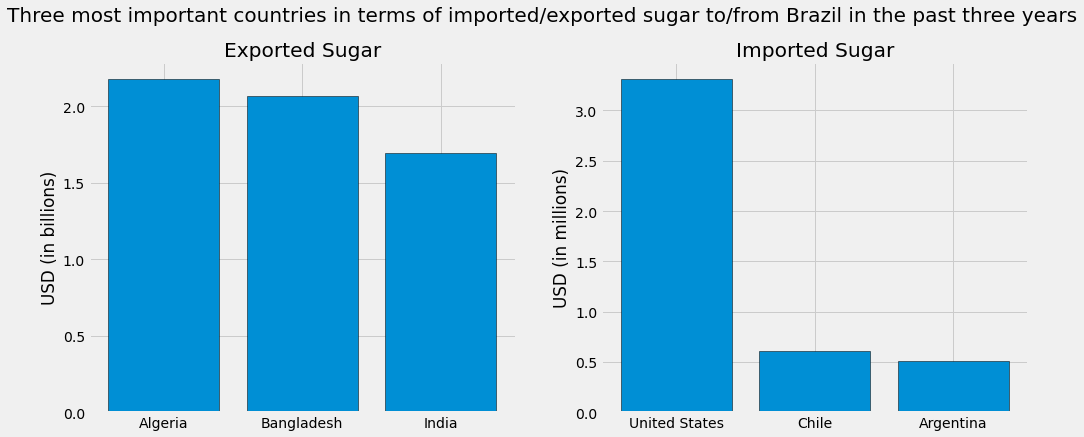

In [589]:
# sugar
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.bar(exported_sugar['country'].head(3), exported_sugar['usd'].head(3)/1e9, ec='k')
plt.ylabel('USD (in billions)')
plt.title('Exported Sugar')

plt.subplot(122)
plt.bar(imported_sugar['country'].head(3), imported_sugar['usd'].head(3)/1e6, ec='k')
plt.ylabel('USD (in millions)')
plt.title('Imported Sugar')

plt.suptitle('Three most important countries in terms of imported/exported sugar to/from Brazil in the past three years', 
             x=0.5, y=1.01, fontsize=20)
plt.show()

In terms of exported sugar, the most important countries are Algeria, Bangladesh and India, while in terms of imported sugar, the most important trade partners are United States, Chile and Argentina. Note that the unit in the value imported is different from the exported. In the exported we have USD in billions, while in the imported we have millions.

### For each of the products in the dataset, show the 5 most important states in terms of exports?

In [603]:
# grouping by product and state for exports
data = comexstat[(comexstat['type'] == 'Export')][['state', 'product', 'usd']]
data = data.groupby(['product', 'state'], as_index=False)['usd'].sum()

In [610]:
# getting a dictionary of dataframes for each product with total amount of usd sorted for the 5 most important
# states
dict_df = {}
for p in products:
    dict_df[p] = data[data['product'] == p].sort_values(by='usd', ascending=False).head(5)

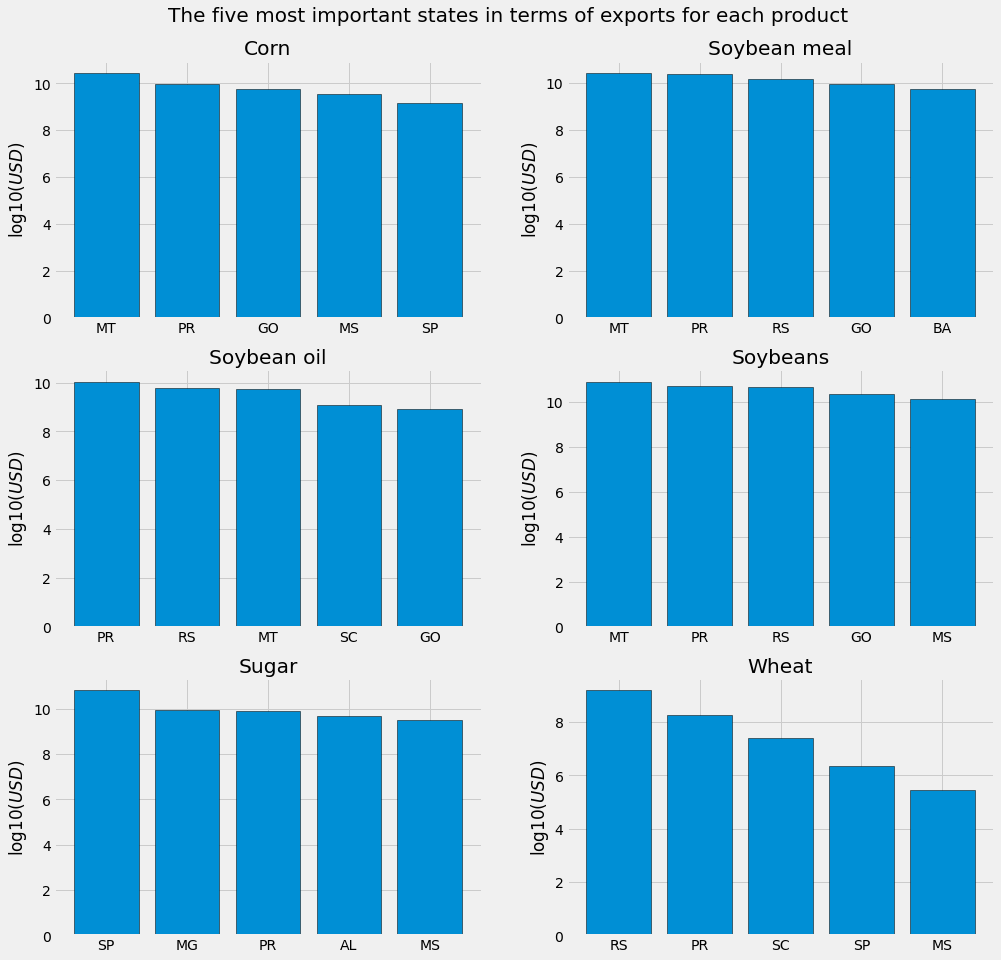

In [635]:
# plotting the graph for each product for the 5 most important states in terms of exports
plt.figure(figsize=(15,15))
for i, p in enumerate(products):    
    plt.subplot(3, 2, i+1)
    x = dict_df[p]['state']
    y = np.log10(dict_df[p]['usd'])
    plt.bar(x, y, ec='k')
    plt.ylabel('$\log10(USD)$')
    title = p.replace('_', ' ')
    plt.title(f'{title.capitalize()}')

plt.suptitle('The five most important states in terms of exports for each product', 
             x=0.5, y=0.93, fontsize=20)
plt.show()

Let's put the the 5 most important states in terms of exports for each product:

- corn: MT, PR, GO, MS, SP
- soybean meal: MT, PR, RS, GO, BA
- soybean oil: MT, PR, RS, GO, MS
- soybeans: PR, RS, MT, SC, GO
- sugar: SP, MG, PR, AL, MS
- wheat: RS, PR, SC, SP, MS

MT has the most importance in three of the six products shown here (corn, soybean meal and soybean oil).

### What should be the total brazilian soybeans, soybean_meal, and corn export forecasts, in tons, for the next 11 years (2020-2030)? 

In [636]:
covariates = pd.read_excel('covariates.xlsx')

In [641]:
# checking info of covariates
# one row with null value
covariates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                52 non-null     int64  
 1   price_soybeans      51 non-null     float64
 2   price_corn          51 non-null     float64
 3   price_soybean_meal  51 non-null     float64
 4   gdp_china           52 non-null     float64
 5   gdp_iran            52 non-null     float64
 6   gpd_netherlands     51 non-null     float64
 7   gdp_spain           52 non-null     float64
 8   gdp_thailand        52 non-null     float64
 9   gdp_world           52 non-null     float64
 10  gdp_egypt           52 non-null     float64
 11  gdp_japan           52 non-null     float64
 12  gdp_vietnam         52 non-null     float64
dtypes: float64(12), int64(1)
memory usage: 5.4 KB


In [649]:
data = comexstat[(comexstat['product'].isin(['corn', 'soybeans', 'soybean_meal'])) & 
                 (comexstat['type'] == 'Export')][['date', 'country', 'tons']]

In [668]:
# getting the countries that most exports those products from Brazil to check if their gdp will have large
# influence on how many tons of products will be exported
data.groupby('country')['tons'].sum().sort_values(ascending=False).head(14)

country
China          4.656180e+08
Netherlands    1.344946e+08
Spain          7.177903e+07
Iran           6.810070e+07
France         5.425710e+07
South Korea    5.206115e+07
Germany        4.423067e+07
Thailand       4.188738e+07
Japan          4.152570e+07
Vietnam        3.168818e+07
Taiwan         2.990496e+07
Italy          2.351696e+07
Indonesia      2.159061e+07
Egypt          1.925888e+07
Name: tons, dtype: float64

All countries mentioned in 'covariates.xlsx' appears between the 14 most important exporters of soybeans, soybean_meal and corn from Brazil.

As we do not have data from before 1997 in the comexstat.csv, data from before that date in covariates will have no use.

In [970]:
# getting total tons exported by year for soybeans, soybean_meal and corn.
y = data.groupby(pd.Grouper(key='date', freq="YS"))['tons'].sum()

In [971]:
# getting values from 1997 to 2019
X = covariates[(covariates['year'] >= 1997) & (covariates['year'] < 2020)] 
X.set_index('year', inplace=True)

In [972]:
# getting covariates from 2020 to 2030 (11 years)
X_to_forecast = covariates[(covariates['year'] >= 2020)]
X_to_forecast.set_index('year', inplace=True)

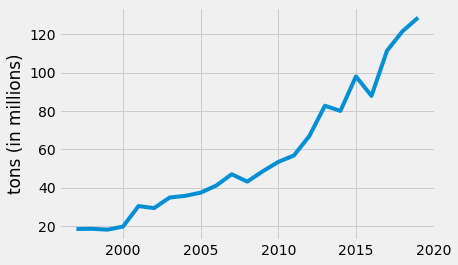

In [997]:
# plotting behaviour of tons in time
plt.plot(y.index.year, y/1e6)
plt.ylabel('tons (in millions)')
plt.show()

We see that the amount of tons exported seems to be increasing exponentially. If we plot how the covariates behave with time, we see that most of them are increasing too.

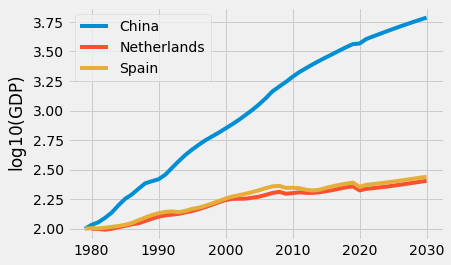

In [1017]:
plt.plot(covariates.year, np.log10(covariates['gdp_china']), label='China')
plt.plot(covariates.year, np.log10(covariates['gpd_netherlands']),  label='Netherlands')
plt.plot(covariates.year, np.log10(covariates['gdp_spain']),  label='Spain')
plt.ylabel('$\log10{(\mathrm{GDP})}$')
plt.legend()
plt.show()

We see from the graph from above that the gdp of the main buyers have an approximately exponetial increase.

As many machine learning models usually do better in scaled data, we will scale the variable by the maximum absolute value, since they do not have orders of magnitude difference. For the target, we will apply the log and than apply maximum absolute scaler, to make the data easier to deal with.

In [974]:
# scaling the data
from sklearn.preprocessing import MaxAbsScaler
scalerx = MaxAbsScaler()
scalery = MaxAbsScaler()

# variables
X_trans = scalerx.fit_transform(X)
X_to_forecast_trans = scalerx.transform(X_to_forecast)

# target
y_trans = np.log10(y)
y_trans = scalery.fit_transform(y_trans.values.reshape(-1, 1))

We will apply some Linear Regression using Elastic Net regression that helps to maintain only the variables that are most important to the model. Besides that, to evaluate the model we will apply cross validation with 10 folds, since we have small dataset.

In [975]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

# creating model
elasticnet = ElasticNet(random_state=0, tol=0.00001, max_iter=100000)
# parameters to be tuned
param_el = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1., 10., 100.], 
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
# cross validation with 10 folds. We do not have much data.
clf1 = GridSearchCV(elasticnet, param_el, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
clf1.fit(X_trans, y_trans)

GridSearchCV(cv=10,
             estimator=ElasticNet(max_iter=100000, random_state=0, tol=1e-05),
             n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                   100.0],
                         'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
             scoring='neg_mean_absolute_error')

In [1002]:
# best score
-clf1.best_score_

0.006136931190817359

We see that the mean absolute error is low, which tells us that this model may be a good model.

Now, let's predict the next 11 years with our model.

In [979]:
# predicting and inverse scaling the target prediction
prediction = clf1.predict(X_to_forecast_trans)
prediction = scalery.inverse_transform(prediction.reshape(-1,1))
prediction = 10**(prediction)

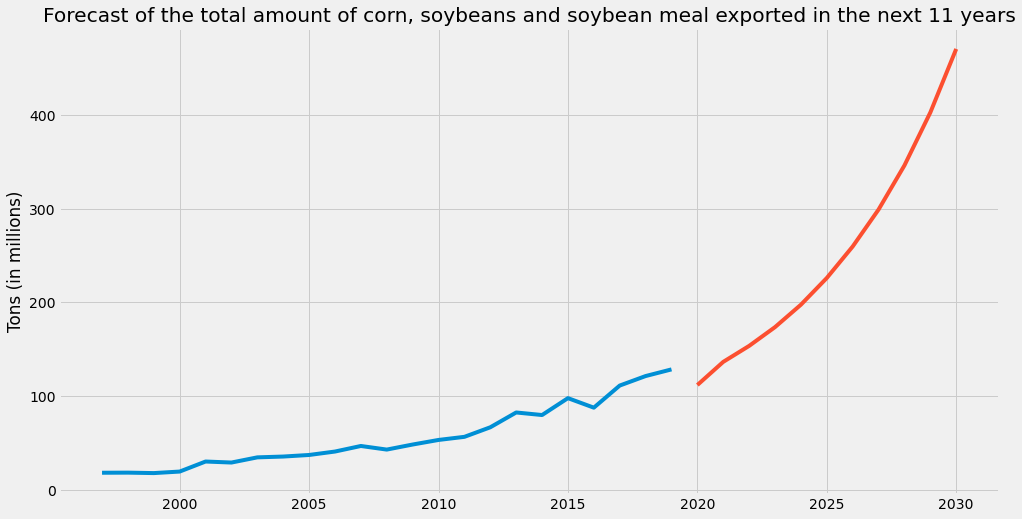

In [993]:
# plotting result
plt.figure(figsize=(15,8))
plt.plot(np.arange(1997, 2020), y/1e6)
plt.plot(np.arange(2020, 2031), prediction/1e6)
plt.ylabel('Tons (in millions)')
plt.title('Forecast of the total amount of corn, soybeans and soybean meal exported in the next 11 years')
plt.show()

In [1014]:
print((prediction[-1, 0]-y[-1])/y[-1])

2.6543741987886156


In [1018]:
print(prediction[-1, 0])

470180730.9125368


As we expected, the total amount of tons in corn, soybeans and soybean meal exported by Brazil will increase exponetially. From 2019 until 2030 the total amount exported will increase 265%, which is a huge increase. In 2030, the model says we will export a total amount of about 470 millions of tons.